In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns

## Feature Engineering

Gather all the features and alter them for model input for train and test.

## Data Loading

In [2]:
df_train_original = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')
df_train = df_train_original.copy()
df_train.head()

,id,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,0,male,36,189.0,82.0,26.0,101.0,41.0,150.0
1,1,female,64,163.0,60.0,8.0,85.0,39.7,34.0
2,2,female,51,161.0,64.0,7.0,84.0,39.8,29.0
3,3,male,20,192.0,90.0,25.0,105.0,40.7,140.0
4,4,female,38,166.0,61.0,25.0,102.0,40.6,146.0


In [3]:
df_test = pd.read_csv('/kaggle/input/playground-series-s5e5/train.csv')

In [4]:
df_eval = df_test[['id', 'Calories']].copy()
df_eval.head()

,id,Calories
0,0,150.0
1,1,34.0
2,2,29.0
3,3,140.0
4,4,146.0


## Data Transformation

In [5]:
def clean_data(df):
    df['Sex'] = pd.get_dummies(df['Sex'], drop_first=True)
    df = df.drop(['id'], axis=1)
    return df

df_train = clean_data(df_train)
df_train.head()

,Sex,Age,Height,Weight,Duration,Heart_Rate,Body_Temp,Calories
0,True,36,189.0,82.0,26.0,101.0,41.0,150.0
1,False,64,163.0,60.0,8.0,85.0,39.7,34.0
2,False,51,161.0,64.0,7.0,84.0,39.8,29.0
3,True,20,192.0,90.0,25.0,105.0,40.7,140.0
4,False,38,166.0,61.0,25.0,102.0,40.6,146.0


In [6]:
df_test = clean_data(df_test)

## Multicollinearity check

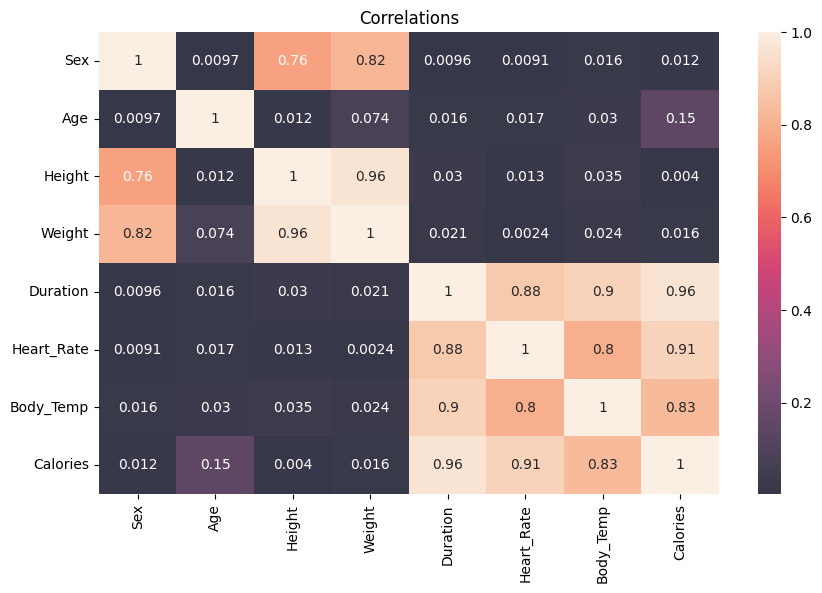

In [7]:
corr = df_train.corr().abs()
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, alpha=0.8)
plt.title('Correlations')
plt.show()

In [8]:
#Correlation with target
df_corr = corr['Calories'].drop(['Calories'], axis=0).sort_values(ascending=False)
df_corr.index

Index(['Duration', 'Heart_Rate', 'Body_Temp', 'Age', 'Weight', 'Sex',
       'Height'],
      dtype='object')

### Examining relationship of each feature with the target

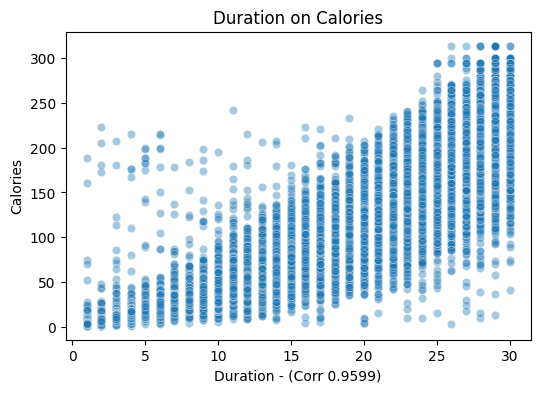

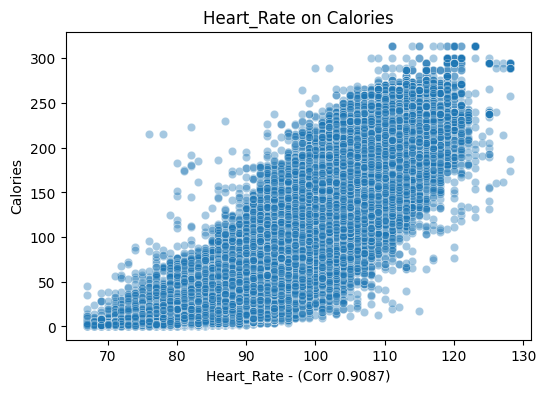

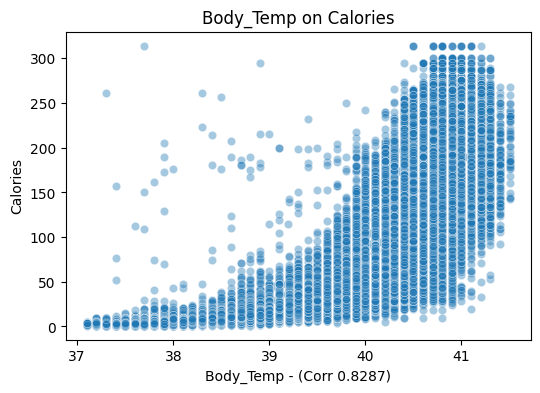

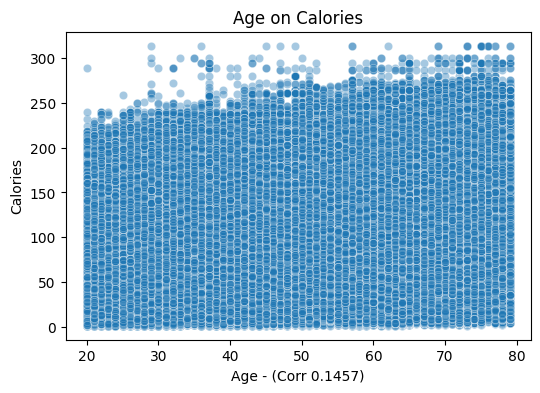

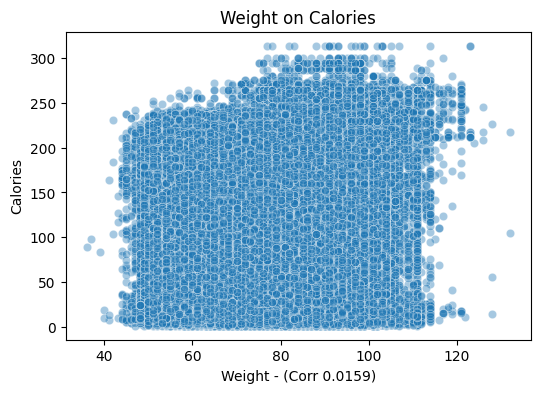

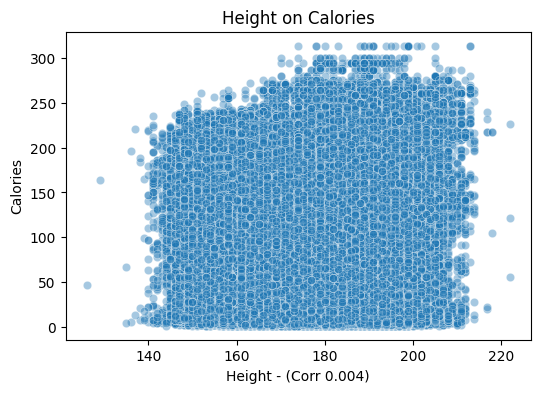

In [9]:
for feature in df_corr.index:
    if not pd.api.types.is_bool_dtype(df_train[feature]):
        plt.figure(figsize=(6,4))
        sns.scatterplot(x = df_train[feature], y = df_train['Calories'], alpha=0.4)
        plt.title(f'{feature} on Calories')
        plt.xlabel(f'{feature} - (Corr {df_corr.loc[feature].round(4)})')
        plt.ylabel('Calories')
        plt.show()
        

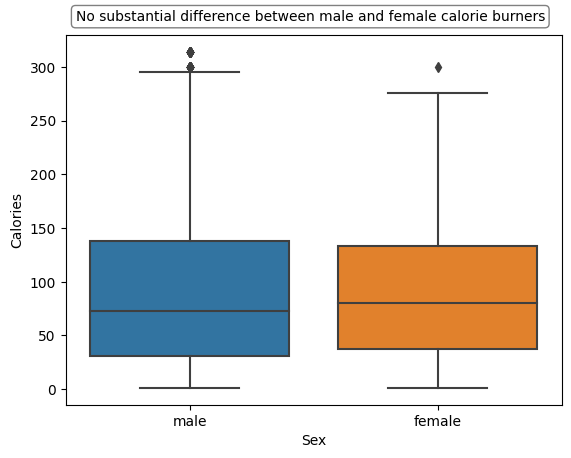

In [10]:
ax = sns.boxplot(x=df_train_original['Sex'],y=df_train['Calories'])

textstr = 'No substantial difference between male and female calorie burners'
props = dict(boxstyle='round', facecolor='white', edgecolor='grey')

plt.text(0.02, 1.05, textstr, transform=ax.transAxes, fontsize=10,
         verticalalignment='center', bbox=props)
plt.show()

In [11]:
corr_features = set()
drop_features = set()
for i in range(len(corr.drop(['Calories'], axis=1).columns)):
    for j in range(i):
        if corr.iloc[i,j] >= 0.9:
            if df_corr[corr.columns[i]] > df_corr[corr.columns[j]]:
                name = (corr.columns[i],corr.columns[j])
                drop_features.add(corr.columns[j])
            else:
                name = (corr.columns[j],corr.columns[i])
                drop_features.add(corr.columns[i])
            corr_features.add(name)
print(corr_features)
print(drop_features)

{('Duration', 'Body_Temp'), ('Weight', 'Height')}
{'Body_Temp', 'Height'}


## Linear Regression
Experimenting with Linear Regression. Performing Linear Regresssion by choosing the features which have highest linear correlation (Pearson's Corr Coeff) with target one by one. Since the evaluation metric is RMSLE, direct calculation of RMSLE won't work as some of the predictions are negative. Log transformed the target to calculate RMSLE.

In [12]:
X_train = df_train.drop(['Calories'], axis=1)
y_train = df_train['Calories']
X_test = df_test.drop(['Calories'], axis=1)
y_test = df_test['Calories']
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [13]:
def model_fit(feature_list):
    
    X_train = df_train[feature_list]
    X_test = df_test[feature_list]
    model = LinearRegression()
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)
    print(y_pred[0:5])
    rmsle = mean_squared_error(y_test_log, y_pred_log, squared=False) #rmse on log y is same as rmsle
    r_squared = r2_score(y_test, y_pred)

    return rmsle, r_squared, y_pred

feature_list = []
for feature in df_corr.index:
    
    feature_list.append(feature)
    rmsle, r_squared, y_pred = model_fit(feature_list)
    
    print(f'Feature List: {feature_list}')
    print(f'RMSLE: , {rmsle}')
    print(f'R² Score:, {r_squared}')

[196.92299162  27.12689669  24.23744938 176.59056527 176.59056527]
Feature List: ['Duration']
RMSLE: , 0.3282874519944907
R² Score:, 0.7865557024244352
[173.19373802  24.94436235  22.27321238 176.73465466 163.51911626]
Feature List: ['Duration', 'Heart_Rate']
RMSLE: , 0.3064695387912335
R² Score:, 0.8008142571693059
[183.21524089  30.77510553  31.34665054 160.02848531 138.72694683]
Feature List: ['Duration', 'Heart_Rate', 'Body_Temp']
RMSLE: , 0.20281377254727906
R² Score:, 0.9106307945321543
[176.9944328   35.32021683  33.15071738 140.64756818 136.06163169]
Feature List: ['Duration', 'Heart_Rate', 'Body_Temp', 'Age']
RMSLE: , 0.18142833190993854
R² Score:, 0.9199322040916955
[175.59166478  35.90516869  33.53381103 138.38745864 137.8567878 ]
Feature List: ['Duration', 'Heart_Rate', 'Body_Temp', 'Age', 'Weight']
RMSLE: , 0.180924275212541
R² Score:, 0.9178965707060253
[172.36974385  35.92042819  33.84915994 138.18929344 138.67454657]
Feature List: ['Duration', 'Heart_Rate', 'Body_Temp',

In [14]:
for i in feature_list:
    if i in drop_features:
        feature_list.remove(i)
print(feature_list)

rmsle, r_squared, y_pred = model_fit(feature_list)
df_eval['Linear'] = y_pred
print(f'Feature List: {feature_list}')
print(f'RMSLE: , {rmsle}')
print(f'R² Score:, {r_squared}')

['Duration', 'Heart_Rate', 'Age', 'Weight', 'Sex']
[161.86857428  29.76120599  24.45319187 149.89263252 163.33781434]
Feature List: ['Duration', 'Heart_Rate', 'Age', 'Weight', 'Sex']
RMSLE: , 0.2887610986376365
R² Score:, 0.7952282393826346


## Other Model options
For this particular dataset structure and multicollinear data we can try Ridge, Lasso, ElasticNet and tree based model like XGBoost, Random Forest where we do not need to explicitly drop collinear features.
Choose the best hyperparameter for each model.

In [15]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

results = []

#Ideally set this with the best estimator, but since it took so long to run GridSearchCV, I set it here
models = {
    "Ridge": Ridge(alpha=1.0),
    "Lasso": Lasso(alpha=0.01),
    "ElasticNet": ElasticNet(alpha=0.01, l1_ratio=0.5),
    "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": XGBRegressor(n_estimators=100, random_state=42, verbosity=0)
}

for name, model in models.items():
    model.fit(X_train, y_train_log)
    y_pred_log = model.predict(X_test)
    y_pred = np.expm1(y_pred_log)  # Convert back to original scale
    df_eval[name] = y_pred
    rmsle = mean_squared_error(y_test_log, y_pred_log, squared=False)
    results.append((name, rmsle))

results_df = pd.DataFrame(results, columns=["Model", "RMSLE"]).sort_values("RMSLE")
print(results_df)


          Model     RMSLE
3  RandomForest  0.024043
4       XGBoost  0.058922
0         Ridge  0.179912
2    ElasticNet  0.182153
1         Lasso  0.182978


In [16]:
df_eval.head()

,id,Calories,Linear,Ridge,Lasso,ElasticNet,RandomForest,XGBoost
0,0,150.0,161.868574,169.746826,173.039663,172.876669,149.689915,147.689621
1,1,34.0,29.761206,35.749064,34.989277,35.133220,34.330886,36.119179
2,2,29.0,24.453192,34.079956,32.333492,32.588662,28.990020,28.774965
3,3,140.0,149.892633,137.396046,139.464762,139.141021,138.626209,137.080505
4,4,146.0,163.337814,137.841927,139.932004,139.641330,145.630190,145.403320


In [17]:
rmsle = mean_squared_log_error(y_test, df_eval['RandomForest'], squared=False)
print("RMSLE:", rmsle)

RMSLE: 0.024043493007044153


## Submission

In [18]:
submission=pd.read_csv('/kaggle/input/playground-series-s5e5/sample_submission.csv')
submission['Calories'] = df_eval['RandomForest']
submission.to_csv('submission_result.csv' ,index=False)
submission.head()

,id,Calories
0,750000,149.689915
1,750001,34.330886
2,750002,28.990020
3,750003,138.626209
4,750004,145.630190
